In this notebook we'll use the example of graphite to demonstrate how to run castep calculations with various dispersion corrections. 


In [ ]:
# ASE version 3.22.1
from ase.io import read, write
from ase.calculators.castep import Castep
from ase.io.castep import read_seed
from ase.visualize import view

# pandas version 1.3.4
import pandas as pd

# castep.mpi on path already, version 21.11
castep_cmd = 'mpirun -n 4 castep.mpi'

# plotting default settings
from matplotlib import pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
%matplotlib inline



In [ ]:
!castep.serial --version

## Separation of layers


In [ ]:
# run in this directorsy
directory = 'separate-layers-tutorial/'

# k-point grid -- not converged! 
kpts  = [13,13,5]
# xc functional to use
xc = 'PBE' 
# range of unit c parameters in Angstroms (interlayer spacings are half these!)
crange = [4, 5, 6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 8.5, 10, 14, 16]

#SEDC correction schemes to try:
schemes = ['', 'G06', 'D3', 'D3-BJ', 'TS', 'MBD', 'XDM']

# pandas dataframe to store the results
df = pd.DataFrame({'crange' : crange})

# loop over the different correction schemes
for sedc_scheme in schemes:
    print('\n',50*'=')
    print(f'{xc} + {sedc_scheme}\n')
    
    # list to temporarily hold the total energy for each calculation
    energies = []

    # loop over c parameters:
    for c in crange:
        label = f'{xc}-{sedc_scheme}-{c:3.2f}'
        try:
            graphite = read_seed(directory+label)
        except:
            # if the calculation doesn't already exist, we set it up and 
            # run it


            # read in cif file (taken from here: https://materialsproject.org/materials/mp-48 )
            graphite = read('C_mp-48_primitive.cif')

            # we could make a supercell to get more accurate results for TS, MBD and XDM schemes.  
            # graphite = graphite * (3,3,1)

            # scale c parameter to new value
            cellpar = graphite.cell.cellpar()
            cellpar[2] = c
            graphite.set_cell(cellpar, scale_atoms=True)
            
            # set up castep calculator
            calc = Castep(xc = xc,
                        kpts = kpts, 
                        label = label, 
                        castep_command = castep_cmd, 
                        basis_precision = 'precise',  # switch to something cheaper (e.g. FINE) to speed things up for this example..
                        directory = directory,
                        write_checkpoint = 'None', # don't need the checkpoint files now
                        write_cst_esp = False, # don't need the electrostatic potential file now
                        write_bands   = False, # don't need the bands file now
                        _rename_existing_dir = False, # allows us to write all these calculations to the same directory... 
                        symmetry_generate = True, # use symmetry to speed up the calculation
                        snap_to_symmetry = True,  # enforce symmetry
                        )
            
            # Switch on the SEDC flags 
            if sedc_scheme != '':
                calc.param.sedc_apply = True
                calc.param.sedc_scheme = sedc_scheme
            
            # For the XDM scheme we need to set this manually
            # otherwise the calculation crashes... 
            if sedc_scheme == 'XDM':
                calc.param.SEDC_SC_XDM = 1.0
                
            graphite.set_calculator(calc)
        e = graphite.get_potential_energy()
        energies.append(e)
        print(f'{c:8.3f} A\t {e:12.8f} eV')
    # save the energy wrt to furthest energy: 
    energies =  [e - energies[-1] for e in energies]
    df[f'{xc}-{sedc_scheme}']  =energies


# Save to a .csv file: 
df.to_csv('graphite_layer_separation.csv')

## read in data



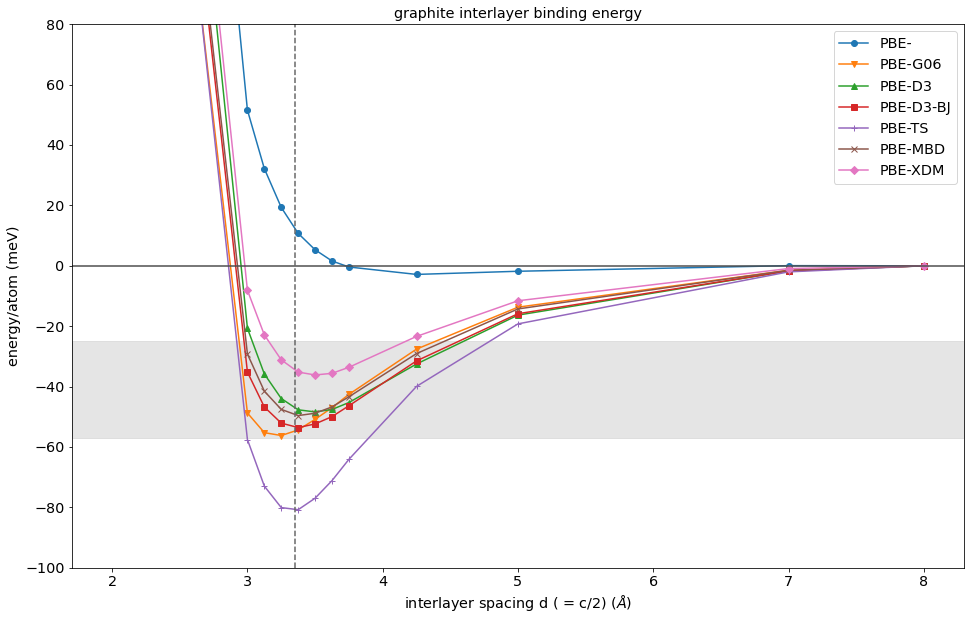

In [12]:
df  = pd.read_csv('./graphite_layer_separation.csv')
dfdiff = (df.iloc[:,1:]) * 1000 / 4 # energy per atom in meV
dfdiff['c/2'] = df['crange'] / 2

styles = [f'{m}-' for m in ["o","v","^","s","+","x","D"]]

# REF: # https://pubs.rsc.org/en/contsent/articlehtml/2014/ra/c3ra47187j
ax = dfdiff.plot(x='c/2', y=['PBE-','PBE-G06', 'PBE-D3', 'PBE-D3-BJ', 'PBE-TS', 'PBE-MBD', 'PBE-XDM'],
                 ylabel='energy/atom (meV)',
                 ylim=(-100, 80), 
                 xlabel=r'interlayer spacing d ( = c/2) (${\AA}$)',
                 figsize = (16,10),
                 style=styles,
                 )
ax.axhline(0, color='0.3')
ax.axvline(3.355, ls='--', color='0.4') 
# Experimental binding energies reported shown in the figure are 31 ± 2, 43, 52 ± 5 and 35 (+15 to –10) meV per atom
ax.axhspan(ymin=-57, ymax=-25, color='0.8', alpha=0.5)
ax.set_title('graphite interlayer binding energy')
plt.savefig('graphite-interlayer-binding-castep-dispersions.pdf')
plt.savefig('graphite-interlayer-binding-castep-dispersions.png', dpi=300)
